<h1 align="center"> HOUSE PRICES ADVANCED REGRESSION TECHNIQUES </h1>

<h1 align="center">![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png) <h1/>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler,MinMaxScaler
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style
style.use('seaborn-colorblind')

import warnings  
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


<h2>Before we Begin:  </h2>
In models with a lot of variables, as in this dataset, you may not always have time to understand the meaning of all variables and what they are. For example, I usually try to make more than 300 variables meaningful. Sometimes this figure exceeds thousands. In such cases, someone has to tell us which variable is important and what are the meanings of them. A corelation matrix is usually can tell, but this alone is not enough. It is also necessary to use the techniques that regression models offer us.<br><br>

<h2> Introduction </h2>
In this notebook we will use various predictive models to see how accurate they  are.<br>
Then combine them and try to improve model performance and analyzing best parameters<br>
<font color='red'>
### Our goal is create a Auto Machine Learning model for any dataset.<br>
<font color='black'>
Let's Begin

<font color='red'>

<h2> Road Map: </h2>
1. [Parameters](#1)  
1. [Understand the Target (SalePrice) distribution](#2)  
1. [Drop high null ratio features](#3)
1. [Fill null values with Mode/Median (for categorical features -Mode and for numbers-Median)](#4)
1. [Auto Detect Outliers](#5)
1. [Check Skewness and fit transormations if needed](#6)
1. [Check Correlation between features and remove features with high correlations](#7)
1. [Create regression models and compare the accuracy to our best regressor.](#8)
1. [Find best model and make a submission](#9)
1. [Improving models performance with StackingCVRegressor](#10)
1. [Create stacked model and make a new submission](#11)
1. [Use Shap and find features importances](#12)



First Import Data

In [2]:
train_l=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_l=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
desc=pd.read_fwf("/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt")
dataset =  pd.concat(objs=[train_l, test_l], axis=0,sort=False).reset_index(drop=True)
sample=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")


<a id='1'></a><br>
## 1. Parameters

In [3]:
n_r=0.6                # Remove Null value ratio more than n_r. For example 0.6 means if column null ratio more than %60 then remove column
s_r=0.50               # If skewness more than %75 transform column to get normal distribution
c_r=1                  # Remove correlated columns
n_f= dataset.shape[1]  # n_f number of features. dataset.shape[1] means all columns. If you change it to 10, it will select 10 most correlated feature
r_s=42                  # random seed

<a id='2'></a><br>
## 2. Understand the Target (SalePrice) distribution

Skewness: 1.8828757597682129
Kurtosis: 6.5362818600645305


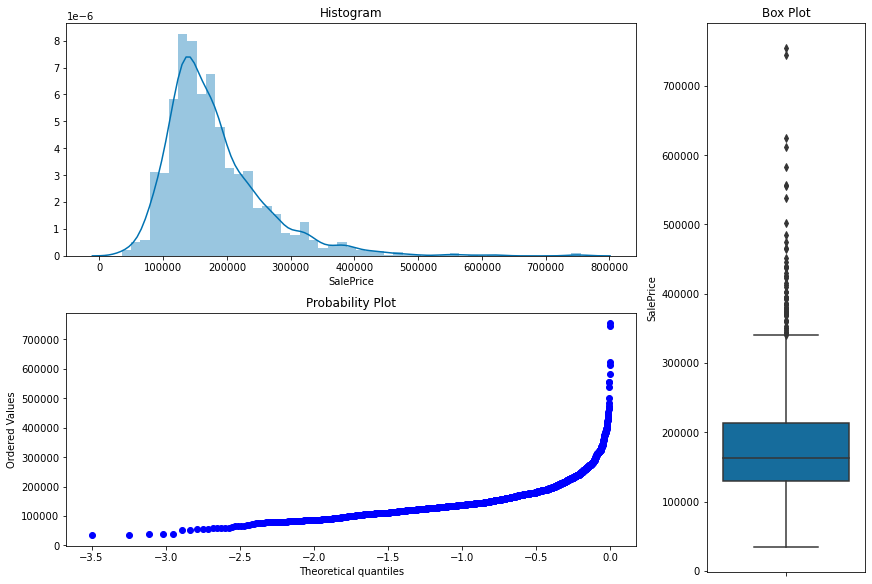

In [4]:
def plotting_3_chart(df, feature): 
    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## crea,ting a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
 

print('Skewness: '+ str(dataset['SalePrice'].skew())) 
print("Kurtosis: " + str(dataset['SalePrice'].kurt()))
plotting_3_chart(dataset, 'SalePrice')

We have skewed target so we need to transofmation. I ll use log but you try other transformation

In [5]:
#log transform the target:
dataset["SalePrice"] = np.log1p(dataset["SalePrice"])

Skewness: 0.12134661989685332
Kurtosis: 0.809519155707878


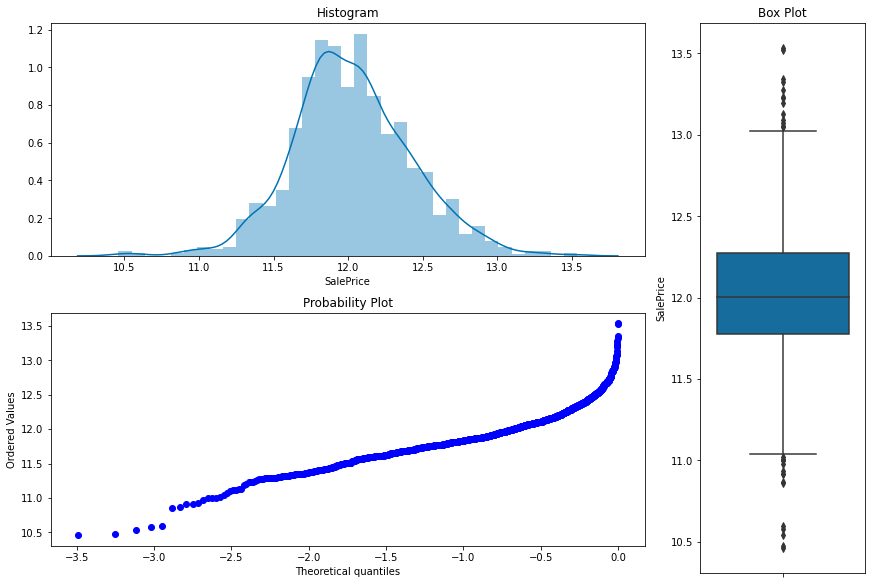

In [6]:
print('Skewness: '+ str(dataset['SalePrice'].skew()))   
print("Kurtosis: " + str(dataset['SalePrice'].kurt()))
plotting_3_chart(dataset, 'SalePrice')

Now our Target normalized. 
<font color='red'>
Note: When making submission , this transofmation need to be undone.

<a id='3'></a><br>
## 3. Drop high null ratio features

You can change null ratio (n_r) on parameters section

In [7]:

dataset_isna=dataset.isna()
dataset_isna_sum=dataset_isna.sum()
dataset_isna_ratio=dataset_isna_sum/len(dataset)
if "SalePrice" in dataset_isna_ratio:
    dataset_isna_ratio.drop("SalePrice",inplace=True)
remove_columns=dataset_isna_ratio[dataset_isna_ratio>n_r]
columns=pd.DataFrame(remove_columns)
print("This Columns will be remove because of null ratio higher than %"+str(n_r*100)+": ")
print(remove_columns)
dataset=dataset.drop(columns.index,axis=1)

This Columns will be remove because of null ratio higher than %60.0: 
Alley          0.932169
PoolQC         0.996574
Fence          0.804385
MiscFeature    0.964029
dtype: float64


<a id='4'></a><br>
## 4. Fill null values with Mode/Median (for categorical features -Mode and for numbers-Median)

I use mode for cats and for median for numeric features but you can change it whatever you want.

In [8]:
cat=dataset.select_dtypes("object")
for column in cat:
    dataset[column].fillna(dataset[column].mode()[0], inplace=True)
    #dataset[column].fillna("NA", inplace=True)


fl=dataset.select_dtypes(["float64","int64"]).drop("SalePrice",axis=1)
for column in fl:
    dataset[column].fillna(dataset[column].median(), inplace=True)
    #dataset[column].fillna(0, inplace=True)



<a id='5'></a><br>
## 5. Auto Detect Outliers

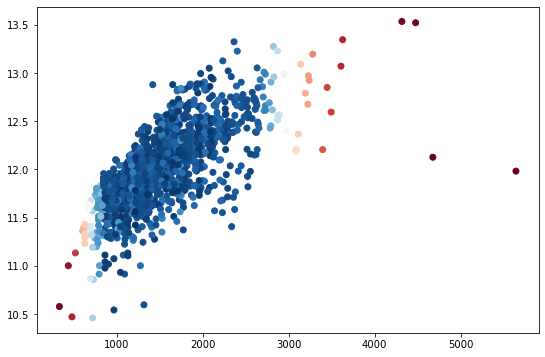

In [9]:
train_o=dataset[dataset["SalePrice"].notnull()]
from sklearn.neighbors import LocalOutlierFactor
def detect_outliers(x, y, top=5, plot=True):
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1)
    x_ =np.array(x).reshape(-1,1)
    preds = lof.fit_predict(x_)
    lof_scr = lof.negative_outlier_factor_
    out_idx = pd.Series(lof_scr).sort_values()[:top].index
    if plot:
        f, ax = plt.subplots(figsize=(9, 6))
        plt.scatter(x=x, y=y, c=np.exp(lof_scr), cmap='RdBu')
    return out_idx

outs = detect_outliers(train_o['GrLivArea'], train_o['SalePrice'],top=5)
outs
plt.show()

In [10]:
outs

Int64Index([1298, 523, 1182, 691, 533], dtype='int64')

Detect and Remove outliers

In [11]:
from collections import Counter
outliers=outs
all_outliers=[]
numeric_features = train_o.dtypes[train_o.dtypes != 'object'].index
for feature in numeric_features:
    try:
        outs = detect_outliers(train_o[feature], train_o['SalePrice'],top=5, plot=False)
    except:
        continue
    all_outliers.extend(outs)

print(Counter(all_outliers).most_common())
for i in outliers:
    if i in all_outliers:
        print(i)
train_o = train_o.drop(train_o.index[outliers])
test_o=dataset[dataset["SalePrice"].isna()]
dataset =  pd.concat(objs=[train_o, test_o], axis=0,sort=False).reset_index(drop=True)

[(0, 4), (533, 4), (1298, 4), (1270, 3), (375, 3), (523, 3), (635, 3), (634, 3), (976, 3), (975, 3), (978, 3), (977, 3), (313, 2), (335, 2), (916, 2), (1213, 2), (812, 2), (229, 2), (77, 2), (7, 2), (599, 2), (953, 2), (496, 2), (1182, 2), (954, 2), (597, 2), (1163, 2), (1350, 2), (1328, 2), (495, 2), (1459, 1), (1, 1), (1458, 1), (1457, 1), (164, 1), (873, 1), (589, 1), (555, 1), (46, 1), (707, 1), (1306, 1), (124, 1), (1369, 1), (249, 1), (706, 1), (451, 1), (636, 1), (1100, 1), (304, 1), (508, 1), (218, 1), (1442, 1), (1058, 1), (240, 1), (1166, 1), (591, 1), (277, 1), (771, 1), (1140, 1), (1223, 1), (1023, 1), (385, 1), (1004, 1), (982, 1), (699, 1), (219, 1), (790, 1), (930, 1), (1028, 1), (695, 1), (645, 1), (1149, 1), (125, 1), (574, 1), (332, 1), (440, 1), (1024, 1), (1373, 1), (431, 1), (1400, 1), (185, 1), (170, 1), (1009, 1), (88, 1), (691, 1), (738, 1), (188, 1), (326, 1), (624, 1), (298, 1), (1283, 1), (53, 1), (189, 1), (809, 1), (48, 1), (203, 1), (434, 1), (1218, 1), (6

<a id='5'></a><br>
## 5. Check Skewness and fit transormations if needed

In [12]:
from scipy.special import boxcox1p
from scipy.stats import boxcox
lam = 0.15

#log transform skewed numeric features:
numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > s_r]
skewed_feats = skewed_feats.index

dataset[skewed_feats] = boxcox1p(dataset[skewed_feats],lam)


### Now we don't have any missing value

In [13]:
dataset.columns[dataset.isnull().any()]

Index(['SalePrice'], dtype='object')

<a id='6'></a><br>
## 6. Check Correlation between features and remove features with high correlations

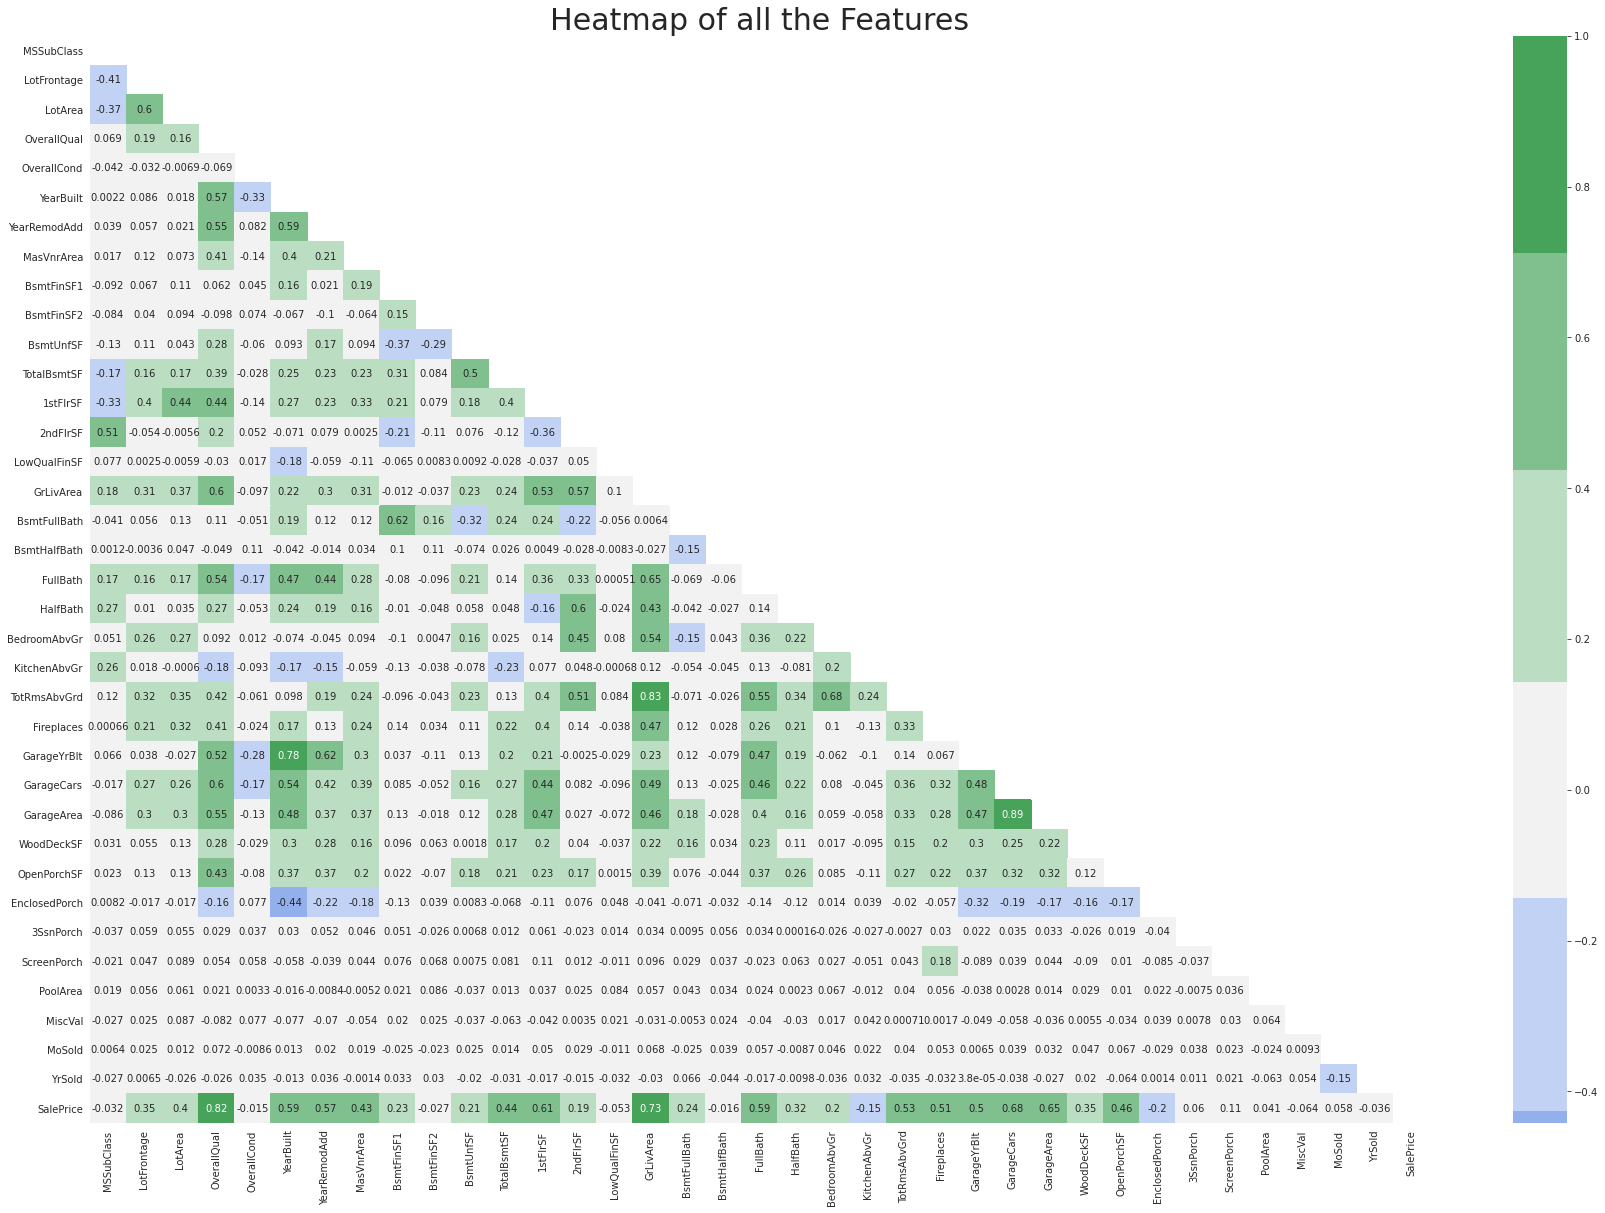

In [14]:
train_heat=dataset[dataset["SalePrice"].notnull()]
train_heat=train_heat.drop(["Id"],axis=1)
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train_heat.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train_heat.corr(), 
            cmap=sns.diverging_palette(255, 133, l=60, n=7), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

Remove correlated features

In [15]:
feature_corr = train_heat.corr().abs()
target_corr=dataset.corr()["SalePrice"].abs()
target_corr=pd.DataFrame(target_corr)
target_corr=target_corr.reset_index()
feature_corr_unstack= feature_corr.unstack()
df_fc=pd.DataFrame(feature_corr_unstack,columns=["corr"])
df_fc=df_fc[(df_fc["corr"]>=.80)&(df_fc["corr"]<1)].sort_values(by="corr",ascending=False)
df_dc=df_fc.reset_index()

#df_dc=pd.melt(df_dc, id_vars=['corr'], var_name='Name')
target_corr=df_dc.merge(target_corr, left_on='level_1', right_on='index',
          suffixes=('_left', '_right'))

cols=target_corr["level_0"].values

target_corr

,level_0,level_1,corr,index,SalePrice
0,GarageCars,GarageArea,0.886477,GarageArea,0.653737
1,GarageArea,GarageCars,0.886477,GarageCars,0.678889
2,GrLivArea,TotRmsAbvGrd,0.828014,TotRmsAbvGrd,0.534469
3,TotRmsAbvGrd,GrLivArea,0.828014,GrLivArea,0.730257
4,OverallQual,SalePrice,0.817543,SalePrice,1.000000
5,SalePrice,OverallQual,0.817543,OverallQual,0.817543


In [16]:
dataset=dataset.drop(["GarageArea","TotRmsAbvGrd"],axis=1)

* Converting categorical features to numerical (some models doesn't need this conversion)

In [17]:
dataset=pd.get_dummies(dataset,columns=cat.columns)


Remove low features with low variances

In [18]:
all_features = dataset.keys()
# Removing features.
dataset = dataset.drop(dataset.loc[:,(dataset==0).sum()>=(dataset.shape[0]*0.9994)],axis=1)
dataset = dataset.drop(dataset.loc[:,(dataset==1).sum()>=(dataset.shape[0]*0.9994)],axis=1) 
# Getting and printing the remaining features.
remain_features = dataset.keys()
remov_features = [st for st in all_features if st not in remain_features]
print(len(remov_features), 'features were removed:', remov_features)

11 features were removed: ['Utilities_AllPub', 'Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior2nd_Other', 'Heating_Floor', 'Electrical_Mix']


<a id='7'></a><br>
## 7. Create regression models and compare the accuracy to our best regressor

In [19]:
train=dataset[dataset["SalePrice"].notnull()]
test=dataset[dataset["SalePrice"].isna()]


In [20]:
k = n_f # if you change it 10 model uses most 10 correlated features
corrmat=abs(dataset.corr())
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
train_x=train[cols].drop("SalePrice",axis=1)
train_y=train["SalePrice"]
X_test=test[cols].drop("SalePrice",axis=1)

* Train Test Split - Classic

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.20, random_state=r_s)

<a id='8'></a><br>
## 8. Find best model and make a submission

Do you know all models names in sckitlearn?


In [22]:

from sklearn.utils.testing import all_estimators
from sklearn import base

estimators = all_estimators()

for name, class_ in estimators:
    if issubclass(class_, base.RegressorMixin):
       print(name+"()")

ARDRegression()
AdaBoostRegressor()
BaggingRegressor()
BayesianRidge()
CCA()
DecisionTreeRegressor()
DummyRegressor()
ElasticNet()
ElasticNetCV()
ExtraTreeRegressor()
ExtraTreesRegressor()
GaussianProcessRegressor()
GradientBoostingRegressor()
HistGradientBoostingRegressor()
HuberRegressor()
IsotonicRegression()
KNeighborsRegressor()
KernelRidge()
Lars()
LarsCV()
Lasso()
LassoCV()
LassoLars()
LassoLarsCV()
LassoLarsIC()
LinearRegression()
LinearSVR()
MLPRegressor()
MultiOutputRegressor()
MultiTaskElasticNet()
MultiTaskElasticNetCV()
MultiTaskLasso()
MultiTaskLassoCV()
NuSVR()
OrthogonalMatchingPursuit()
OrthogonalMatchingPursuitCV()
PLSCanonical()
PLSRegression()
PassiveAggressiveRegressor()
RANSACRegressor()
RadiusNeighborsRegressor()
RandomForestRegressor()
RegressorChain()
Ridge()
RidgeCV()
SGDRegressor()
SVR()
StackingRegressor()
TheilSenRegressor()
TransformedTargetRegressor()
VotingRegressor()
_SigmoidCalibration()


In [23]:
np.random.seed(seed=r_s)

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge,RidgeCV,BayesianRidge,LinearRegression,Lasso,LassoCV,ElasticNet,RANSACRegressor,HuberRegressor,PassiveAggressiveRegressor,ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import CCA
from sklearn.neural_network import MLPRegressor



my_regressors=[ 
               ElasticNet(alpha=0.001,l1_ratio=0.70,max_iter=100,tol=0.01, random_state=r_s),
               ElasticNetCV(l1_ratio=0.9,max_iter=100,tol=0.01,random_state=r_s),
               CatBoostRegressor(logging_level='Silent',random_state=r_s),
               GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber',random_state =r_s),
               LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       random_state=r_s
                                       ),
               RandomForestRegressor(random_state=r_s),
               AdaBoostRegressor(random_state=r_s),
               ExtraTreesRegressor(random_state=r_s),
               SVR(C= 20, epsilon= 0.008, gamma=0.0003),
               Ridge(alpha=6),
               RidgeCV(),
               BayesianRidge(),
               DecisionTreeRegressor(),
               LinearRegression(),
               KNeighborsRegressor(),
               Lasso(alpha=0.00047,random_state=r_s),
               LassoCV(),
               KernelRidge(),
               CCA(),
               MLPRegressor(random_state=r_s),
               HistGradientBoostingRegressor(random_state=r_s),
               HuberRegressor(),
               RANSACRegressor(random_state=r_s),
               PassiveAggressiveRegressor(random_state=r_s)
               #XGBRegressor(random_state=r_s)
              ]

regressors=[]

for my_regressor in my_regressors:
    regressors.append(my_regressor)


scores_val=[]
scores_train=[]
MAE=[]
MSE=[]
RMSE=[]


for regressor in regressors:
    scores_val.append(regressor.fit(X_train,y_train).score(X_val,y_val))
    scores_train.append(regressor.fit(X_train,y_train).score(X_train,y_train))
    y_pred=regressor.predict(X_val)
    MAE.append(mean_absolute_error(y_val,y_pred))
    MSE.append(mean_squared_error(y_val,y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_val,y_pred)))

    
results=zip(scores_val,scores_train,MAE,MSE,RMSE)
results=list(results)
results_score_val=[item[0] for item in results]
results_score_train=[item[1] for item in results]
results_MAE=[item[2] for item in results]
results_MSE=[item[3] for item in results]
results_RMSE=[item[4] for item in results]


df_results=pd.DataFrame({"Algorithms":my_regressors,"Training Score":results_score_train,"Validation Score":results_score_val,"MAE":results_MAE,"MSE":results_MSE,"RMSE":results_RMSE})
df_results

,Algorithms,Training Score,Validation Score,MAE,MSE,RMSE
0,"ElasticNet(alpha=0.001, copy_X=True, fit_inter...",0.906823,0.910005,0.087505,0.016112,0.126935
1,"ElasticNetCV(alphas=None, copy_X=True, cv=None...",0.878647,0.888022,0.098077,0.020048,0.141592
2,<catboost.core.CatBoostRegressor object at 0x7...,0.989735,0.910642,0.085283,0.015998,0.126484
3,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.984902,0.900045,0.089669,0.017896,0.133775
4,"LGBMRegressor(bagging_fraction=0.75, bagging_f...",0.952992,0.897082,0.091327,0.018426,0.135743
5,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.979983,0.892674,0.092845,0.019215,0.138619
6,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.857968,0.843656,0.122942,0.027991,0.167306
7,"(ExtraTreeRegressor(ccp_alpha=0.0, criterion='...",0.999991,0.907187,0.090203,0.016617,0.128906
8,"SVR(C=20, cache_size=200, coef0=0.0, degree=3,...",0.944162,0.900442,0.084361,0.017825,0.133508
9,"Ridge(alpha=6, copy_X=True, fit_intercept=True...",0.909844,0.912661,0.086399,0.015637,0.125048


Sort models results according to RMSE and select best model for submission.

In [24]:
best_models=df_results.sort_values(by="RMSE")
best_model=best_models.iloc[0][0]
best_stack=best_models["Algorithms"].values
best_models

,Algorithms,Training Score,Validation Score,MAE,MSE,RMSE
10,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.912108,0.915551,0.085709,0.015119,0.122961
15,"Lasso(alpha=0.00047, copy_X=True, fit_intercep...",0.908595,0.912740,0.086467,0.015623,0.124991
9,"Ridge(alpha=6, copy_X=True, fit_intercept=True...",0.909844,0.912661,0.086399,0.015637,0.125048
17,"KernelRidge(alpha=1, coef0=1, degree=3, gamma=...",0.908560,0.910822,0.088237,0.015966,0.126357
2,<catboost.core.CatBoostRegressor object at 0x7...,0.989735,0.910642,0.085283,0.015998,0.126484
11,"BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, al...",0.908383,0.910340,0.086893,0.016052,0.126698
0,"ElasticNet(alpha=0.001, copy_X=True, fit_inter...",0.906823,0.910005,0.087505,0.016112,0.126935
7,"(ExtraTreeRegressor(ccp_alpha=0.0, criterion='...",0.999991,0.907187,0.090203,0.016617,0.128906
13,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.912893,0.905458,0.087387,0.016927,0.130102
22,"RANSACRegressor(base_estimator=None, is_data_v...",0.879626,0.900831,0.095420,0.017755,0.133247


In [25]:

best_model.fit(X_train,y_train)
y_test=best_model.predict(X_test)
test_Id=test['Id']
my_submission = pd.DataFrame({'Id': test_Id, 'SalePrice': np.expm1(y_test)})
my_submission.to_csv('submission_bm.csv', index=False)
print("Model Name: "+str(best_model))
print(best_model.score(X_val,y_val))
y_pred=best_model.predict(X_val)
print("RMSE: "+str(np.sqrt(mean_squared_error(y_val,y_pred))))

Model Name: RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
0.9155512917463804
RMSE: 0.1229610963268829


How is look like our predictions. Are they close to real target values? <br>
Let's look at the graph

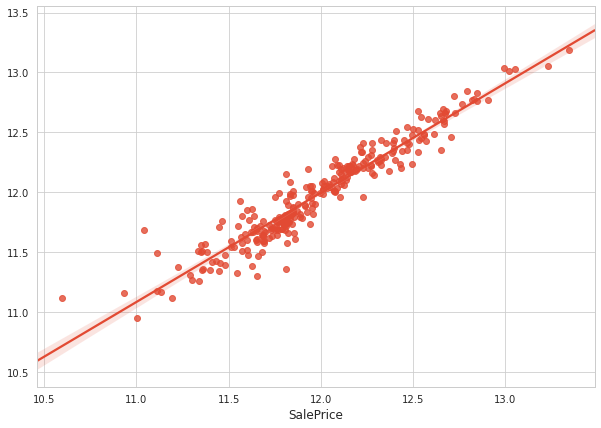

In [26]:
plt.figure(figsize=(10,7))
y_pred=best_model.predict(X_val)
sns.regplot(x=y_val,y=y_pred,truncate=False)
plt.show()

<a id='9'></a><br>
## 9. Improving models performance with StackingCVRegressor

<h1 align="center">![](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor_files/stacking_cv_regressor_overview.png) <h1/>

This code block finds best combinations for you. It's taking time but worth it.

In [27]:
i_num=[]
j_num=[]
score=[]
RMSE=[]
for i in range(1,8):
    stack_models=i
    for j in range(1,4):
        base_model=j
        best_n_models=best_models.head(stack_models).index
        regressors_top_n=list( regressors[i] for i in best_n_models)

        from mlxtend.regressor import StackingCVRegressor
        stack = StackingCVRegressor(regressors=regressors_top_n,meta_regressor= best_stack[base_model], use_features_in_secondary=True)
        comb=stack.fit(X_train,y_train)
        y_pred=comb.predict(X_val)
        score.append(comb.score(X_val,y_val))
        RMSE.append(np.sqrt(mean_squared_error(y_val,y_pred)))
        i_num.append(i)
        j_num.append(j)
        
opt_resr=zip(score,RMSE,i_num,j_num)
opt_resr=set(opt_resr)
opt_resr_score=[item[0] for item in opt_resr]
opt_resr_RMSE=[item[1] for item in opt_resr]
opt_resr_i_num=[item[2] for item in opt_resr]
opt_resr_j_num=[item[3] for item in opt_resr]



df_opt_resr=pd.DataFrame({"Score":opt_resr_score,"RMSE":opt_resr_RMSE,"i_num":opt_resr_i_num,"j_num":opt_resr_j_num})
df_opt_resr=df_opt_resr.sort_values(by="RMSE")
opt_best_model_i_num=df_opt_resr.iloc[0][2].astype(int)
opt_best_model_j_num=df_opt_resr.iloc[0][3].astype(int)


<a id='10'></a><br>
## 10. Create stacked model and make a new submission

In [28]:
best_n_models=best_models.head(opt_best_model_i_num).index
regressors_top_n=list( regressors[i] for i in best_n_models)
from mlxtend.regressor import StackingCVRegressor
stack = StackingCVRegressor(regressors=regressors_top_n,meta_regressor= regressors[opt_best_model_j_num], use_features_in_secondary=True)
comb=stack.fit(X_train,y_train)
print(comb.score(X_val,y_val))
y_pred=comb.predict(X_val)
print("RMSE: "+str(np.sqrt(mean_squared_error(y_val,y_pred))))

0.8880316283906277
RMSE: 0.1415855402657429


You can see your models improvement

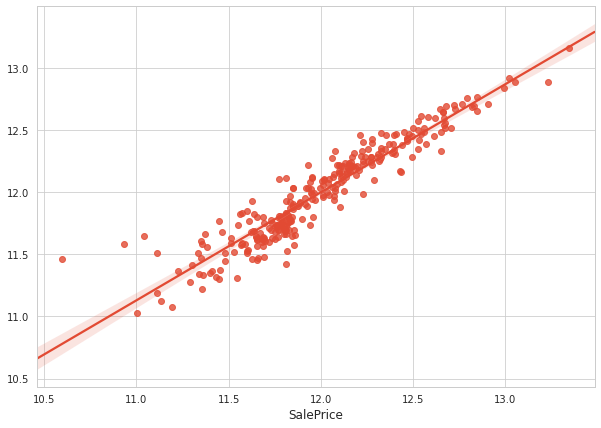

In [29]:
plt.figure(figsize=(10,7))
y_pred=comb.predict(X_val)
sns.regplot(x=y_val,y=y_pred,truncate=False)
plt.show()

In [30]:
y_test=comb.predict(X_test)
test_Id=test['Id']
my_submission = pd.DataFrame({'Id': test_Id, 'SalePrice': np.expm1(y_test)})
#my_submission = pd.DataFrame({'Id': test_Id, 'SalePrice': np.expm1(y_test)})
my_submission.to_csv('submission_stack.csv', index=False)

## Let's try Blending our Models

In [31]:
def blended_predictions(X):
    return ((0.40 * comb.predict(X)) + \
            (0.40 * best_models.iloc[0][0].predict(X)) + \
            (0.10 * best_models.iloc[1][0].predict(X)) + \
            (0.10 * best_models.iloc[2][0].predict(X)))

y_pred=blended_predictions(X_val)


#y_pred=comb.predict(X_val)
print("RMSE: "+str(np.sqrt(mean_squared_error(y_val,y_pred))))

y_test=blended_predictions(X_test)
test_Id=test['Id']
my_submission = pd.DataFrame({'Id': test_Id, 'SalePrice': np.expm1(y_test)})
my_submission.to_csv('submission_blend3.csv', index=False)



RMSE: 0.1271694274575924


<a id='11'></a><br>
## 11. Use Shap and find features importances

Note: SHAP doesnt support all models that we have. So if model which we used is unsupported then we will get error. In my case no problem.

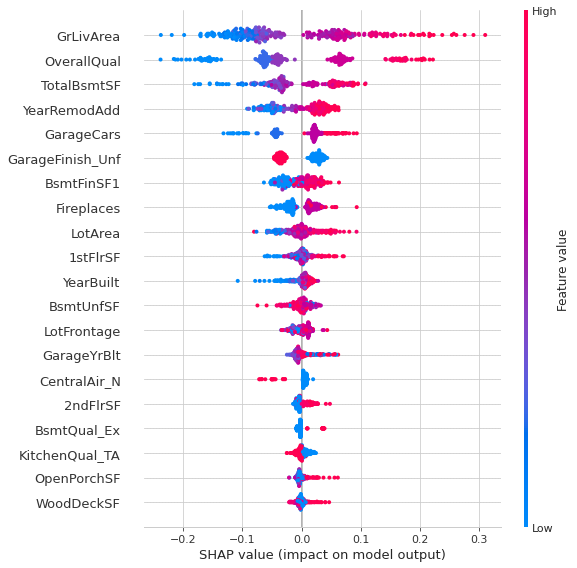

In [32]:
import shap  # package used to calculate Shap values

xgb=XGBRegressor(random_state=2)
xgb=xgb.fit(X_train,y_train)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_val)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_val)


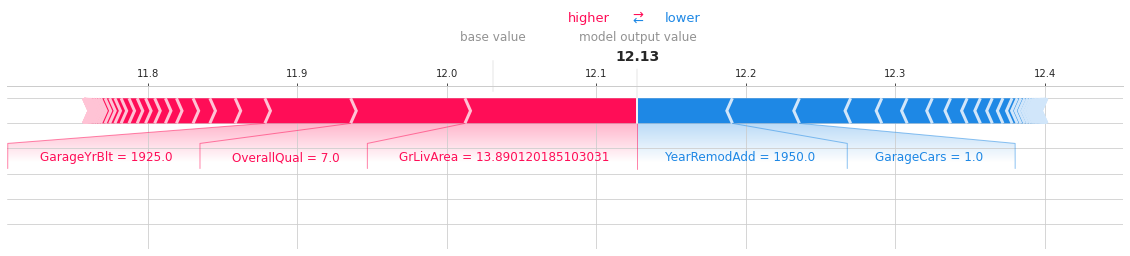

In [33]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:],matplotlib=True)

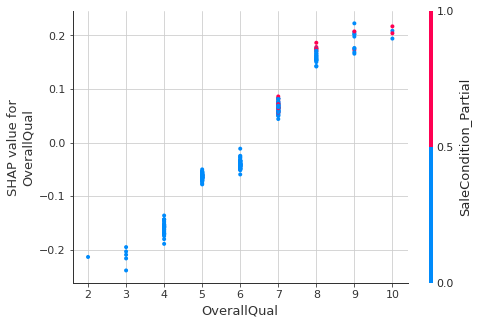

In [34]:
most_corr=dataset.corr()["SalePrice"].abs().sort_values(ascending=False).index[1]
shap.dependence_plot(most_corr, shap_values, X_val, interaction_index="SaleCondition_Partial")
